In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt
import cv2
import time
from PIL import Image

import torch
from torch import nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import torch.backends.cudnn as cudnn
import torch.nn.functional as F
import torch.distributed as dist
import torchvision.models as models
import torchvision.utils as vutils
from torchvision import transforms as T

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using %s device.' % (device))

Using cuda device.


In [3]:
image_size = (64,64)
images_path = "animefaces256cleaner"
batch_size = 128
input_generator_size = 128

'''# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 70 # Original is 5 on a dataset of 1 million

# Learning rate for optimizers
lr = 0.0001

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5'''

'# Size of z latent vector (i.e. size of generator input)\nnz = 100\n\n# Size of feature maps in generator\nngf = 64\n\n# Size of feature maps in discriminator\nndf = 64\n\n# Number of training epochs\nnum_epochs = 70 # Original is 5 on a dataset of 1 million\n\n# Learning rate for optimizers\nlr = 0.0001\n\n# Beta1 hyperparam for Adam optimizers\nbeta1 = 0.5'

In [4]:
image_names = list(os.listdir(images_path))

In [5]:
len(image_names)

92219

In [18]:
sizes = []
for filename in os.listdir(images_path):
    img = cv2.imread(os.path.join(images_path, filename))
    sizes.append(img.shape[0])

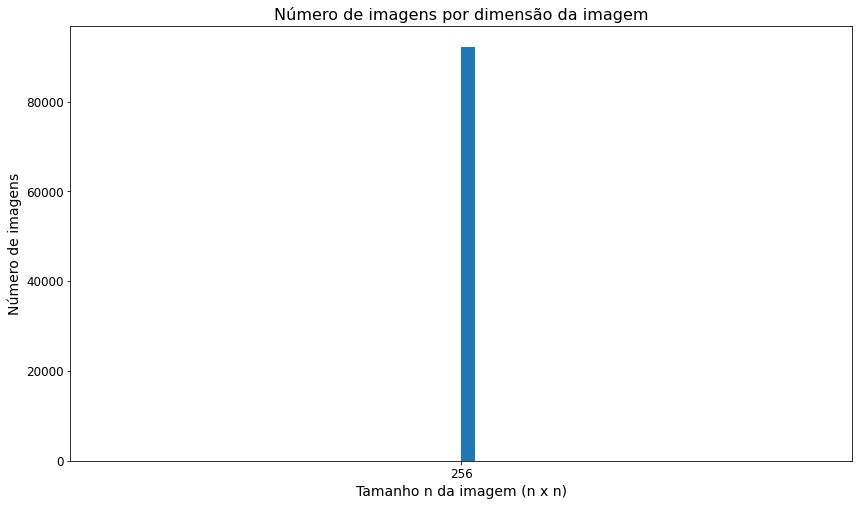

In [33]:
plt.figure(figsize=(14,8))
plt.hist(sizes, bins=50)
plt.title("Número de imagens por dimensão da imagem", fontdict = {'size':'16'})
plt.ylabel("Número de imagens", fontsize=14)
plt.xlabel("Tamanho n da imagem (n x n)", fontsize=14)
plt.xticks(np.arange(min(sizes), max(sizes)+1, 10), fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [6]:
test_plot_indexes = (np.random.rand(4,5) * len(image_names)).astype('int32')

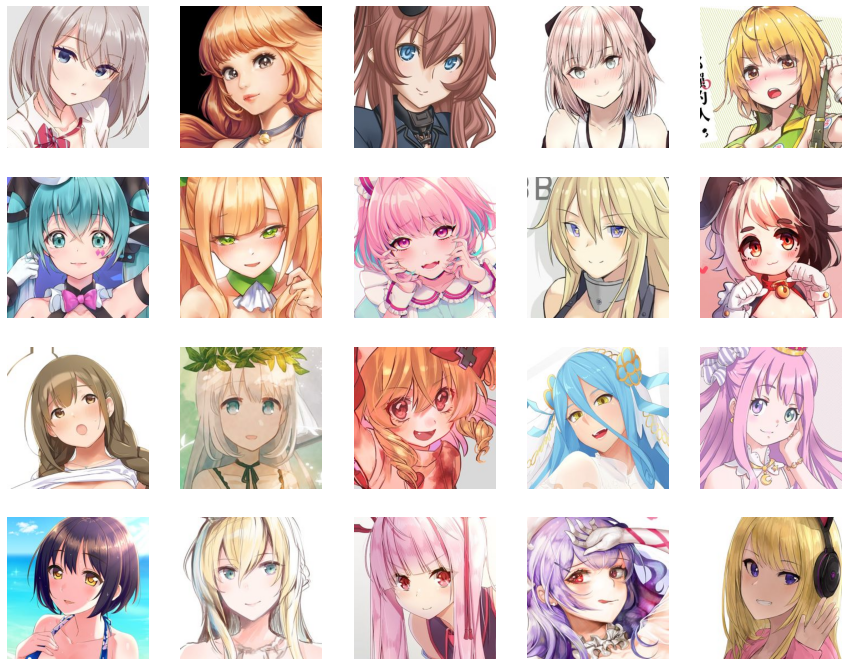

In [7]:
f, axarr = plt.subplots(4,5,figsize=(15,12))

for i in range(len(test_plot_indexes)):
    for j in range(len(test_plot_indexes[i])):
        img = cv2.imread(os.path.join(images_path, image_names[test_plot_indexes[i][j]]))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axarr[i,j].imshow(img)
        axarr[i,j].axis('off')

In [8]:
class GenericDataLoader(object):
    def __init__(self, img_folder, img_names, img_size=90):
        """
        Generic data loader.
        img_folder: path to the dataset to be used.
        img_names: list containing all image names.
        img_size: size to which the images are going to be resized.
        """

        self.img_folder = img_folder
        self.img_size = img_size
        self.img_names = img_names

    def __getitem__(self, index):

        img = cv2.imread(os.path.join(self.img_folder, self.img_names[index]))

        if type(self.img_size) == int or type(self.img_size) == float:
            img = cv2.resize(img, (self.img_size, self.img_size))
        elif type(self.img_size) == tuple and len(self.img_size) == 2:
            img = cv2.resize(img, self.img_size)
        else:
            raise TypeError(f"Image resize to {self.img_size} not defined for type {type(self.img_size)}")

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        img_pil = Image.fromarray(img)

        normalize = T.Normalize(mean=[0.5, 0.5, 0.5],
                                 std=[0.5, 0.5, 0.5])
        img_transforms = T.Compose([T.ToTensor(), normalize])

        img = img_transforms(img_pil)

        return img

    def __len__(self):
        return len(self.img_names)

In [9]:
all_images_dataset = GenericDataLoader(images_path, image_names, image_size)
dataloader = torch.utils.data.DataLoader(all_images_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

Based on DcGan

In [10]:
class Generator_Network(nn.Module):
    def __init__(self):
        super(Generator_Network, self).__init__()
        self.pipeline = nn.Sequential(
            #Entra vetor aleatório de tamanho input_generator_size
            nn.ConvTranspose2d(input_generator_size, 64 * 8, kernel_size=4, stride=1, padding=0, bias=False),#upsample
            nn.BatchNorm2d(64 * 8),
            nn.ReLU(True),

            nn.ConvTranspose2d(64 * 8, 64 * 4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64 * 4),
            nn.ReLU(True),

            nn.ConvTranspose2d( 64 * 4, 64 * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64 * 2),
            nn.ReLU(True),

            nn.ConvTranspose2d( 64 * 2, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.ConvTranspose2d( 64, 3, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
            # Sai com dimensão 3x64x64
        )

    def forward(self, x):
        return self.pipeline(x)

In [11]:
generator = Generator_Network().to(device)
print(generator)

Generator_Network(
  (pipeline): Sequential(
    (0): ConvTranspose2d(128, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): T

In [12]:
class Discriminator_Network(nn.Module):
    def __init__(self):
        super(Discriminator_Network, self).__init__()
        self.pipeline = nn.Sequential(
            #Entra 3x64x64
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 64 * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64 * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64 * 2, 64 * 4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64 * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64 * 4, 64 * 8, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64 * 8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64 * 8, 1, kernel_size=4, stride=1, padding=0, bias=False),
            nn.Flatten(),
            nn.Sigmoid()
            #Sai 1x1x1
        )

    def forward(self, x):
        return self.pipeline(x)

In [13]:
discriminator = Discriminator_Network().to(device)
print(discriminator)

Discriminator_Network(
  (pipeline): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.2, inplace=True)
    (12): Conv2d(512, 1, k

In [14]:
def plot_foreach_epoch(generator, input_generator_images):
    with torch.no_grad():
        generated_images = generator(input_generator_images).detach().cpu()
    L = 8
    f, axarr = plt.subplots(L,L,figsize=(15,15))
    for i in range(L):
        for j in range(L):
            #img = cv2.imread(os.path.join(images_path, image_names[test_plot_indexes[i][j]]))
            #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            axarr[i,j].imshow(np.transpose(generated_images[i*L+j], (1,2,0)))
            axarr[i,j].axis('off')

In [15]:
#Função de Loss (Binary Cross Entropy)
criterion = nn.BCELoss()

#Vetor usado para acompanhar visualmente a evolução do modelo gerador
fixed_noise = torch.randn(64, input_generator_size, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

# Treinamento

In [16]:
num_epochs = 300

#Listas que armazenam progresso
img_list = []
loss_list_gen = []
loss_list_disc = []

lr = 1e-4

#Otimizadores(um para cada modelo)
optimizer_disc = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_gen = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

In [17]:
def train_disc(real_images, criterion, optimizer_disc):
    #TREINAMENTO COM DADOS REAIS
    discriminator.zero_grad()

    #vetor de labels do tamanho do número de imagens apenas com valores 1,
    #já que todas as imagens são reais
    label = torch.full((real_images.size(0),), 1, device=device)
    
    #Forward com o batch de imagens reais
    real_output = discriminator(real_images).view(-1)
    #Calcular loss pros dados reais
    errD_real = criterion(real_output.type(torch.FloatTensor), label.type(torch.FloatTensor))
    #Gradiente
    errD_real.backward()
    real_score = real_output.mean().item()
    
    #TREINAMENTO COM DADOS FALSAS
    #Gerar batch do mesmo tamanho do batch de imagens reais, mas com imagens falsas
    noise = torch.randn(real_images.size(0), input_generator_size, 1, 1, device=device)

    #Gerar imagens falsas com o modelo gerador
    fake_images = generator(noise)
    label = torch.full((real_images.size(0),), 0, device=device)
    #Forward com um batch de imagens falsas
    fake_output = discriminator(fake_images.detach()).view(-1)
    #Calcular loss pros dados falsos
    errD_fake = criterion(fake_output.type(torch.FloatTensor), label.type(torch.FloatTensor))
    #Gradiente
    errD_fake.backward()
    fake_score = fake_output.mean().item()

    #AJUSTES FINAIS
    #Somar valores dos batches falso e real
    errD = errD_real + errD_fake
    
    #Atualizar
    optimizer_disc.step()
    
    return errD, real_score, fake_score

In [18]:
def train_gen(optimizer_gen):
    generator.zero_grad()

    label = torch.full((real_images.size(0),), 1, device=device)

    #TENTANDO ENGANAR REDE DISCRIMINADORA
    noise = torch.randn(real_images.size(0), input_generator_size, 1, 1, device=device)
    #Gerar batch de imagens falsas
    fake_images = generator(noise)
    
    fake_output = discriminator(fake_images).view(-1)

    #Calcular loss de G baseado no output de mandar imagens falsas para o modelo discriminador
    errG = criterion(fake_output.type(torch.FloatTensor), label.type(torch.FloatTensor))
    
    #Gradiente
    errG.backward()

    fake_score = fake_output.mean().item()

    optimizer_gen.step()

    return errG, fake_score

In [19]:
#Contador para indicar se deve ser plotado
iters = 0

checkpoint_path = 'checkpoints/'

#Se o treinamento das redes for interrompido no meio das epochs
resume_training = False
epoch_inicial = 0

In [20]:
#Resumir treino
if resume_training == True:
    generator.load_state_dict(torch.load(os.path.join(checkpoint_path, 'checkpoint_generator.pth')))
    discriminator.load_state_dict(torch.load(os.path.join(checkpoint_path, 'checkpoint_discriminator.pth')))
    with open(os.path.join(checkpoint_path, 'checkpoint_epoch.txt'), "r") as f:
        for line in f:
            epoch_inicial = int(line)        

for epoch in range(epoch_inicial+1, num_epochs):
    #Para cada batch
    for i, data in enumerate(dataloader, 0):
        
        #Ajustando dados do batch
        real_images = data.to(device)

        '''
        #vetor de labels do tamanho do número de imagens apenas com valores 1,
        #já que todas as imagens são reais
        label = torch.full((real_images.size(0),), 1, device=device)

        #TREINAMENTO DO DISCRIMINADOR
        
        #Zerar gradientes
        discriminator.zero_grad()

        #Forward na discriminadora
        output = discriminator(real_images).view(-1)
        #Calcular loss pros dados reais
        errD_real = criterion(output.type(torch.FloatTensor), label.type(torch.FloatTensor))
        #Gradiente
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(real_images.size(0), input_generator_size, 1, 1, device=device)
        # Generate fake image batch with G
        fake = generator(noise)
        label = torch.full((real_images.size(0),), 0, device=device)
        # Classify all fake batch with D
        output = discriminator(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output.type(torch.FloatTensor), label.type(torch.FloatTensor))
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizer_disc.step()'''

        errD, real_score, fake_score = train_disc(real_images, criterion, optimizer_disc)

        '''############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        generator.zero_grad()
        label.fill_(1)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = discriminator(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output.type(torch.FloatTensor), label.type(torch.FloatTensor))
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizer_gen.step()'''
        
        errG, fake_score_2 = train_gen(optimizer_gen)

        #Printar informações por epoch
        if i % 1000 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), real_score, fake_score, fake_score_2))

        #Salvar losses para análise posterior
        loss_list_gen.append(errG.item())
        loss_list_disc.append(errD.item())

        iters += 1

    #Salvar checkpoints para continuar treinamento
    os.makedirs(checkpoint_path, exist_ok = True)
    torch.save(generator.state_dict(), os.path.join(checkpoint_path, 'checkpoint_generator.pth'))
    torch.save(discriminator.state_dict(), os.path.join(checkpoint_path, 'checkpoint_discriminator.pth'))
    file_checkpoint = open(os.path.join(checkpoint_path, 'checkpoint_epoch.txt'), "w")
    file_checkpoint.write(f"{epoch}\n")

    #Salvar modelos intermediários
    if((epoch%100==0) and epoch!=0) or (epoch == num_epochs-1):
        os.makedirs(checkpoint_path, exist_ok = True)
        torch.save(generator.state_dict(), os.path.join(checkpoint_path, f'checkpoint_generator{epoch}.pth'))
        torch.save(discriminator.state_dict(), os.path.join(checkpoint_path, f'checkpoint_discriminator{epoch}.pth'))

    # Check how the generator is doing by saving G's output on fixed_noise
    #Checar evolução do modelo gerador salvando output de G em vetores fixos criados antes do treinamento
    if (epoch % 5 == 0) or (epoch == num_epochs-1):
        with torch.no_grad():
            fake = generator(fixed_noise).detach().cpu()
        img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
        plt.figure(figsize=(10,8))
        plt.imshow(np.transpose(vutils.make_grid(fake, padding=2, normalize=True), (1, 2, 0)))
        plt.axis('off')
        plt.show()

[1/70][0/721]	Loss_D: 1.4500	Loss_G: 8.6728	D(x): 0.4610	D(G(z)): 0.4762 / 0.0002
[2/70][0/721]	Loss_D: 1.4378	Loss_G: 6.9164	D(x): 0.8854	D(G(z)): 0.6926 / 0.0014
[3/70][0/721]	Loss_D: 0.7893	Loss_G: 4.9349	D(x): 0.8039	D(G(z)): 0.3771 / 0.0113
[4/70][0/721]	Loss_D: 0.5802	Loss_G: 5.7466	D(x): 0.8852	D(G(z)): 0.3027 / 0.0053


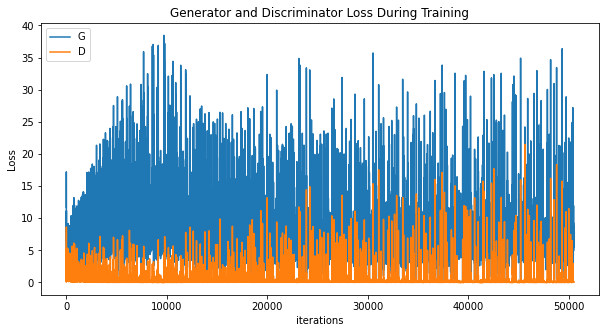

In [20]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(loss_list_gen, label="G")
plt.plot(loss_list_disc, label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [21]:
from IPython.display import HTML
import matplotlib.animation as animation

In [22]:
print(len(img_list))

102


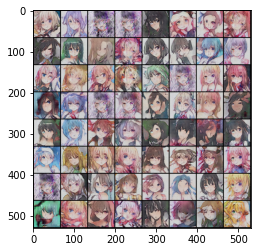

In [23]:
plt.imshow(np.transpose(img_list[55], (1, 2, 0)))

In [76]:
n_tests = 20

noise_post_train = torch.randn(n_tests, input_generator_size, 1, 1, device=device)

In [77]:
noise_post_train.size()

torch.Size([20, 128, 1, 1])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

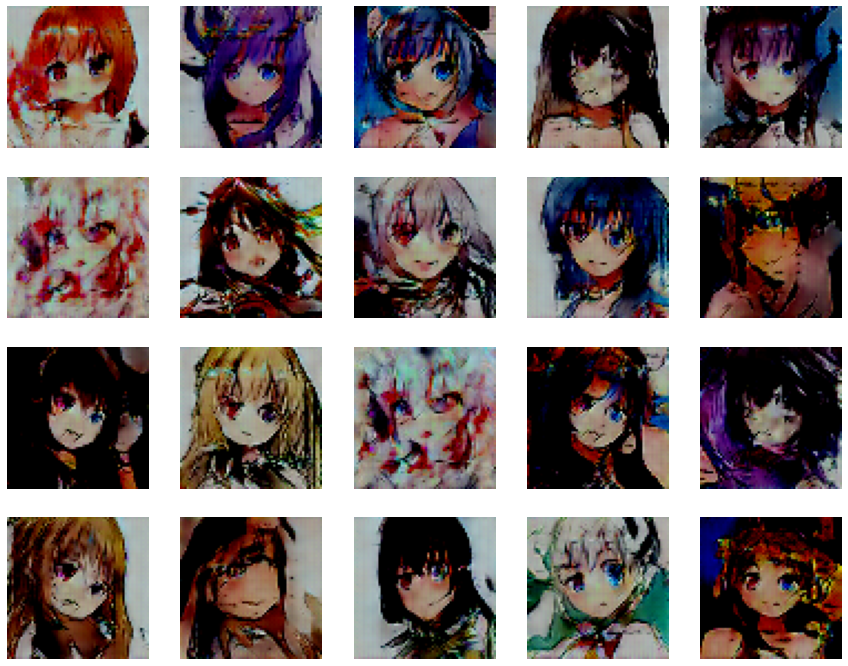

In [78]:
f, axarr = plt.subplots(4,5,figsize=(15,12))
fake_images = generator(noise_post_train)

for i in range(4):
    for j in range(5):
        axarr[i,j].imshow(fake_images.cpu().detach().numpy()[i*5+j].transpose(1,2,0))
        axarr[i,j].axis('off')